In [6]:
# Mount Google Drive to access your dataset
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
import tensorflow as tf
import numpy as np
import warnings
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
import os

# Set seeds and ignore warnings for reproducibility and cleaner output
SEED = 54
tf.random.set_seed(SEED)
np.random.seed(SEED)
warnings.simplefilter('ignore')

# Update dataset paths to Google Drive
BASE_DIR = '/content/drive/MyDrive/AlzymerDataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

IMG_SIZE = (176, 208)
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE


In [11]:
# Load datasets with 20% validation split from training directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
NUM_CLASSES = len(class_names)


Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.
Found 6400 files belonging to 4 classes.


In [12]:
# One-hot encode labels and optimize dataset pipeline
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds_prefetch = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
val_ds_prefetch = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
test_ds_prefetch = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)


In [13]:
# Build the transfer learning model with frozen ResNet50 base
def build_model():
    base_model = ResNet50(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights='imagenet', include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    x = layers.Flatten()(base_model.output)
    output = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

model = build_model()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# Compile and train the model with early stopping
EPOCHS = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'],
)

history = model.fit(
    train_ds_prefetch,
    epochs=EPOCHS,
    validation_data=val_ds_prefetch,
    callbacks=[callback],
)


Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 835s 5s/step - accuracy: 0.5186 - auc: 0.7375 - loss: 5.8184 - val_accuracy: 0.7445 - val_auc: 0.9067 - val_loss: 1.1641
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 833s 5s/step - accuracy: 0.8084 - auc: 0.9429 - loss: 0.7850 - val_accuracy: 0.6875 - val_auc: 0.8677 - val_loss: 1.9832
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 776s 5s/step - accuracy: 0.7677 - auc: 0.9070 - loss: 1.5167 - val_accuracy: 0.7906 - val_auc: 0.9155 - val_loss: 1.3185
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 821s 5s/step - accuracy: 0.8836 - auc: 0.9569 - loss: 0.8017 - val_accuracy: 0.8141 - val_auc: 0.9332 - val_loss: 1.1056
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 816s 5s/step - accuracy: 0.8916 - auc: 0.9631 - loss: 0.7487 - val_accuracy: 0.7937 - val_auc: 0.9028 - val_loss: 1.6643
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 803s 5s/step - accuracy: 0.9032 - auc: 0.9654 - loss: 0.6713 - val_accuracy: 0.8227 - val_auc: 0.9331 - val_loss: 1.2601
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━

In [15]:
# Save the trained model to Colab local directory
save_dir = '/content/alzheimer_model'
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, 'resnet_alzheimer_model.h5')
model.save(model_path)

print(f"Model saved to: {model_path}")


Model saved to: /content/alzheimer_model/resnet_alzheimer_model.h5


In [16]:
# Evaluate the model on test dataset
test_scores = model.evaluate(test_ds_prefetch, verbose=1)
print(f"Test loss: {test_scores[0]:.4f}")
print(f"Test AUC: {test_scores[1]:.4f}")
print(f"Test Accuracy: {test_scores[2]:.4f}")


200/200 ━━━━━━━━━━━━━━━━━━━━ 826s 4s/step - accuracy: 0.9129 - auc: 0.9786 - loss: 0.4082
Test loss: 0.4345
Test AUC: 0.9761
Test Accuracy: 0.9117


In [17]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved model
model_path = '/content/alzheimer_model/resnet_alzheimer_model.h5'
model = tf.keras.models.load_model(model_path)

# Define image size used during training
IMG_SIZE = (176, 208)

# Load and preprocess a single image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)  # Load and resize
    img_array = image.img_to_array(img)  # Convert to array (176, 208, 3)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, 176, 208, 3)
    img_array = img_array / 255.0  # Normalize pixel values [0,1]
    return img_array

# Path to your single test image
img_path = '/content/verymild_95.jpg'

# Prepare the image
img_input = load_and_preprocess_image(img_path)

# Predict
prediction = model.predict(img_input)
predicted_class_index = np.argmax(prediction, axis=1)[0]

# Map index to class name
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
predicted_class_name = class_names[predicted_class_index]

print("Predicted class:", predicted_class_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: VeryMildDemented


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


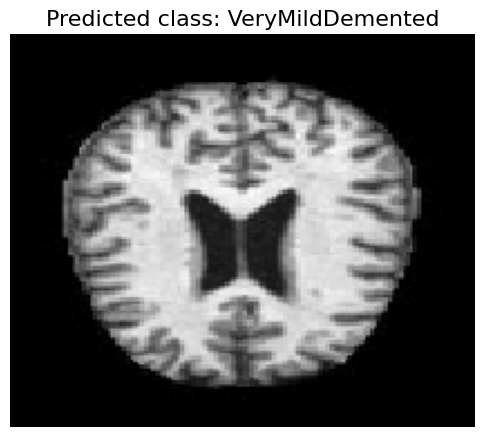

In [18]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the saved model
model_path = '/content/alzheimer_model/resnet_alzheimer_model.h5'
model = tf.keras.models.load_model(model_path)

IMG_SIZE = (176, 208)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img, img_array

# Path to your single test image
img_path = '/content/verymild_95.jpg'
img, img_input = load_and_preprocess_image(img_path)

# Predict
prediction = model.predict(img_input)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class_name = class_names[predicted_class_index]

# Display output label and image
plt.figure(figsize=(6, 6))
plt.title(f"Predicted class: {predicted_class_name}", fontsize=16)
plt.axis('off')
plt.imshow(img)
plt.show()
